In [1]:
import pystan

import numpy as np
import matplotlib.pyplot as plt

In [2]:
eczema_data = {
    'treatment': {
        'alpha': 1,  # fixed prior hyperparameters for the
        'beta': 1,   # beta distribution
        'num_trials': 6,  # number of trials in the data set
        'patients': [23, 16, 16, 45, 31, 10],  # number of patients per trial
        'improved': [20, 10, 13, 35, 22, 7]},  # number of improved patients per trial
    'control': {
        'alpha': 1,
        'beta': 1,
        'num_trials': 6,
        'patients': [15, 18, 10, 39, 29, 10],
        'improved': [9, 11, 4, 21, 12, 0]}}

## Old model
* The same probability of success, $p$, is used in each study.
* The probability of success is unknown and assumed to come from a uniform prior.

$$\begin{align}
p &\sim \text{Beta}(\alpha=1, \beta=1) \\
k_{i} &\sim \text{Binomial}(n_{i}, p) \qquad i=1,2,\ldots 6
\end{align}$$

In [3]:
stan_code = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
data {
    int<lower=1> num_trials;  // number of trials in the data set
    int<lower=0> patients[num_trials];  // number of patients per trial
    int<lower=0> improved[num_trials];  // number of improved patients per trial
    real<lower=0> alpha;  // fixed prior hyperparameter
    real<lower=0> beta;   // fixed prior hyperparameter
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.
parameters {
    real<lower=0,upper=1> p;  // probability of improvement - the
                              // parameter of the binomial likelihood
}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
model {
    p ~ beta(alpha, beta);  // prior over p
    for(i in 1:num_trials) {
        improved[i] ~ binomial(patients[i], p);  // likelihood function
    }
}

"""

In [4]:
# Compile model

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ee893fad8aee952ea79ac031a6d3875a NOW.
/usr/local/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/k8/dkychj2n5c98xy85t13b1md40000gn/T/tmpwpr6ri5b/stanfit4anon_model_ee893fad8aee952ea79ac031a6d3875a_3597339337548162745.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


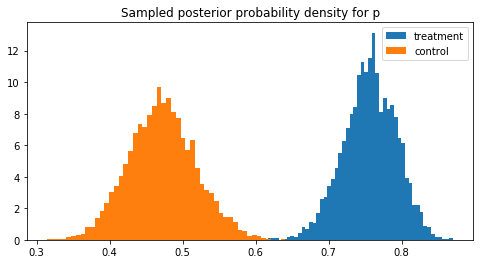

Posterior 95% interval over p for treatment: [0.68269378 0.82353703]
Posterior 95% interval over p for control: [0.38412847 0.56664315]


In [5]:
# Generate posterior samples

results_treatment = stan_model.sampling(data=eczema_data['treatment'])
results_control = stan_model.sampling(data=eczema_data['control'])

# Plot posterior histograms

samples_treatment = results_treatment.extract()
samples_control = results_control.extract()

plt.figure(figsize=(8,4))
plt.hist(samples_treatment['p'], bins=50, density=True, label='treatment')
plt.hist(samples_control['p'], bins=50, density=True, label='control')
plt.title('Sampled posterior probability density for p')
plt.legend()
plt.show()

print('Posterior 95% interval over p for treatment:', np.percentile(samples_treatment['p'], [2.5, 97.5]))
print('Posterior 95% interval over p for control:', np.percentile(samples_control['p'], [2.5, 97.5]))

## New model
* A different probability of success, $p_i$, is used in each study.
* However these probabilities are assumed to come from a common Beta prior with unknown parameters $\alpha$ and $\beta$.
* An exponential prior is placed over $\alpha$ and $\beta$ such that almost all of the probability mass is between 0 and 10.

$$\begin{align}
\alpha &\sim \text{Exponential}(\lambda=0.5) \\
\beta &\sim \text{Exponential}(\lambda=0.5) \\
p_i &\sim \text{Beta}(\alpha, \beta)\\
k_{i} &\sim \text{Binomial}(n_{i}, p_i) \qquad i=1,2,\ldots 6
\end{align}$$

In [6]:
stan_code = """

data {
    int<lower=1> num_trials;  // number of trials in the data set
    int<lower=0> patients[num_trials];  // number of patients per trial
    int<lower=0> improved[num_trials];  // number of improved patients per trial
}

parameters {
    real<lower=0,upper=1> p[num_trials];
    real<lower=0> alpha;
    real<lower=0> beta;
}

model {
    alpha ~ exponential(0.5);
    beta ~ exponential(0.5);
    for(i in 1:num_trials) {
        p[i] ~ beta(alpha, beta);
      improved[i] ~ binomial(patients[i], p[i]);
    }
}

"""

In [7]:
# Compile model

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d9f2012fd953c8933e83db8c44be56dc NOW.
/usr/local/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/k8/dkychj2n5c98xy85t13b1md40000gn/T/tmpnnd4dcl3/stanfit4anon_model_d9f2012fd953c8933e83db8c44be56dc_3792255853951534656.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [8]:
# Generate posterior samples

results_treatment = stan_model.sampling(data=eczema_data['treatment'])
results_control = stan_model.sampling(data=eczema_data['control'])

In [9]:
# Print Stan summary of parameter posteriors

print('\nTreatment group results:\n')
print(results_treatment.stansummary(pars=['p', 'alpha', 'beta'], probs=[0.025, 0.975]))
print('\nControl group results:\n')
print(results_control.stansummary(pars=['p', 'alpha', 'beta'], probs=[0.025, 0.975]))


Treatment group results:

Inference for Stan model: anon_model_d9f2012fd953c8933e83db8c44be56dc.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%  97.5%  n_eff   Rhat
p[1]    0.83  1.0e-3   0.07   0.68   0.94   4586    1.0
p[2]    0.65  1.6e-3    0.1   0.45   0.83   3836    1.0
p[3]    0.79  1.3e-3   0.09   0.59   0.93   4227    1.0
p[4]    0.77  8.8e-4   0.06   0.65   0.87   4428    1.0
p[5]    0.71  1.2e-3   0.08   0.55   0.84   4184    1.0
p[6]    0.71  1.6e-3   0.11   0.47    0.9   4791    1.0
alpha   5.25    0.05   2.61   1.47  11.68   2636    1.0
beta    2.06    0.02   1.02    0.6   4.53   2537    1.0

Samples were drawn using NUTS at Fri Oct 19 12:11:07 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

Control group results:

Inference for Stan model: anon_m

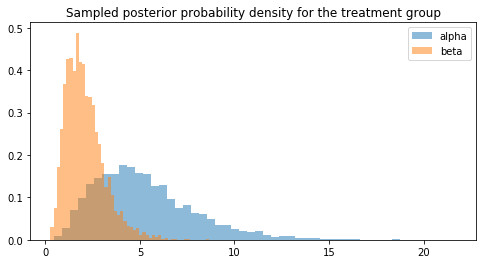

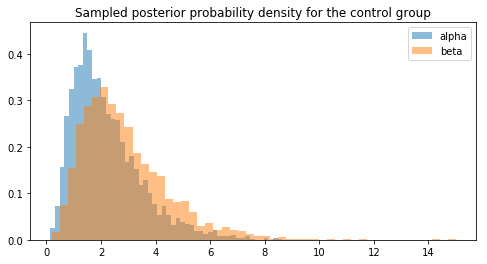

In [10]:
# Generate posterior samples

results_treatment = stan_model.sampling(data=eczema_data['treatment'])
results_control = stan_model.sampling(data=eczema_data['control'])

# Plot posterior histograms

samples_treatment = results_treatment.extract()
samples_control = results_control.extract()

plt.figure(figsize=(8,4))
plt.hist(samples_treatment['alpha'], bins=50, density=True, label='alpha', alpha=0.5)
plt.hist(samples_treatment['beta'], bins=50, density=True, label='beta', alpha=0.5)
plt.title('Sampled posterior probability density for the treatment group')
plt.legend()

plt.figure(figsize=(8,4))
plt.hist(samples_control['alpha'], bins=50, density=True, label='alpha', alpha=0.5)
plt.hist(samples_control['beta'], bins=50, density=True, label='beta', alpha=0.5)
plt.title('Sampled posterior probability density for the control group')
plt.legend()

plt.show()

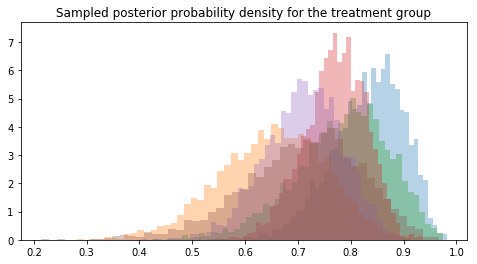

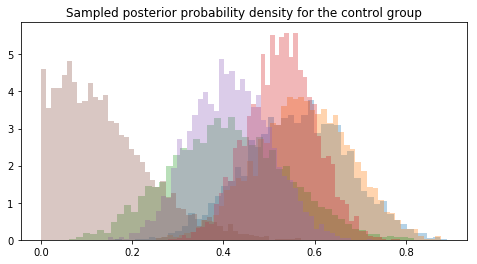

In [11]:
# Posterior histograms over the probabilities of success

plt.figure(figsize=(8,4))
for i in range(6):
    plt.hist(samples_treatment['p'][:,i], bins=50, density=True, alpha=0.33)
plt.title('Sampled posterior probability density for the treatment group')

plt.figure(figsize=(8,4))
for i in range(6):
    plt.hist(samples_control['p'][:,i], bins=50, density=True, alpha=0.33)
plt.title('Sampled posterior probability density for the control group')

plt.show()

In [12]:
import pickle
import pystan

# bernoulli model
model_code = """
    data {
      int<lower=0> N;
      int<lower=0,upper=1> y[N];
    }
    parameters {
      real<lower=0,upper=1> theta;
    }
    model {
      for (n in 1:N)
          y[n] ~ bernoulli(theta);
    }
    """
data = dict(N=10, y=[0, 1, 0, 0, 0, 0, 0, 0, 0, 1])
model = pystan.StanModel(model_code=model_code)
fit = model.sampling(data=data)

with open('model.pkl', 'wb') as f:
    pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)

# load it at some future point
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

# run with different data
fit = model.sampling(data=dict(N=5, y=[1, 1, 0, 1, 0]))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ed12b60d4e79f489850662e92c114122 NOW.
/usr/local/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/k8/dkychj2n5c98xy85t13b1md40000gn/T/tmpev_17cmw/stanfit4anon_model_ed12b60d4e79f489850662e92c114122_2060388122562220537.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
